In [1]:
%load_ext autoreload
%autoreload 2

In [180]:
import h3
import pandas as pd
import geopandas as gpd
import numpy as np
import folium
from src.settings import *
from os.path import join
from shapely.geometry import Polygon
from tqdm.auto import tqdm

In [181]:
tqdm.pandas()

In [40]:
def visualize_hexagons(hexagons, color="red", folium_map=None, width=8):
    """
    hexagons is a list of hexcluster. Each hexcluster is a list of hexagons. 
    eg. [[hex1, hex2], [hex3, hex4]]
    """
    polylines = []
    lat = []
    lng = []
    for hex in hexagons:
        polygons = h3.h3_set_to_multi_polygon([hex], geo_json=False)
        # flatten polygons into loops.
        outlines = [loop for polygon in polygons for loop in polygon]
        polyline = [outline + [outline[0]] for outline in outlines][0]
        lat.extend(map(lambda v:v[0],polyline))
        lng.extend(map(lambda v:v[1],polyline))
        polylines.append(polyline)
    
    if folium_map is None:
        f = folium.Figure(width=1000, height=500)
        m = folium.Map(location=[sum(lat)/len(lat), sum(lng)/len(lng)], zoom_start=13, tiles='cartodbpositron').add_to(f)
    else:
        m = folium_map
    for polyline in polylines:
        my_PolyLine=folium.PolyLine(locations=polyline,weight=width,color=color)
        m.add_child(my_PolyLine)
    return m
    

def visualize_polygon(polyline, color):
    polyline.append(polyline[0])
    lat = [p[0] for p in polyline]
    lng = [p[1] for p in polyline]
    m = folium.Map(location=[sum(lat)/len(lat), sum(lng)/len(lng)], zoom_start=13, tiles='cartodbpositron')
    my_PolyLine=folium.PolyLine(locations=polyline,weight=8,color=color)
    m.add_child(my_PolyLine)
    return m

In [4]:
h3_address = h3.geo_to_h3(51.107883, 17.038538, 8)
m = visualize_hexagons(list(h3.k_ring_distances(h3_address, 1)[1]), color="blue")
m = visualize_hexagons([h3_address], color="red", folium_map=m)

m

In [9]:
place_name = "Wrocław,Poland"
place = gpd.read_file(join(GENERATED_DATA_DIR, place_name, "place.geojson"), driver="GeoJSON")


In [33]:
polygon = place.geometry.item()
polygon_geojson = gpd.GeoSeries([polygon]).__geo_interface__
geometry_geojson = polygon_geojson["features"][0]["geometry"]

In [62]:
h3_hexes = list(h3.polyfill_geojson(geometry_geojson, 8))

In [48]:
f = folium.Figure(width=1000, height=500)
m = folium.Map(location=[51.1078852, 17.0385376], zoom_start=13).add_to(f)

m = visualize_hexagons(h3_hexes, "grey", m, width=2)
m

In [199]:
edges = gpd.read_file(join(GENERATED_DATA_DIR, place_name, "edges_drive.geojson"), driver="GeoJSON")

In [51]:
h3

Index(['index', 'u', 'v', 'key', 'osmid', 'oneway', 'length', 'from', 'to',
       'access', 'junction', 'tunnel', 'oneway_0', 'oneway_1', 'lanes_1',
       'lanes_2', 'lanes_3', 'lanes_4', 'lanes_5', 'lanes_6', 'lanes_7',
       'lanes_None', 'highway_living_street', 'highway_motorway',
       'highway_motorway_link', 'highway_primary', 'highway_primary_link',
       'highway_residential', 'highway_secondary', 'highway_secondary_link',
       'highway_tertiary', 'highway_tertiary_link', 'highway_trunk',
       'highway_trunk_link', 'highway_unclassified', 'maxspeed_10',
       'maxspeed_100', 'maxspeed_110', 'maxspeed_120', 'maxspeed_15',
       'maxspeed_20', 'maxspeed_30', 'maxspeed_40', 'maxspeed_50',
       'maxspeed_60', 'maxspeed_70', 'maxspeed_80', 'maxspeed_90',
       'maxspeed_None', 'bridge_None', 'bridge_viaduct', 'bridge_yes',
       'access_None', 'access_delivery', 'access_destination', 'access_no',
       'access_permissive', 'access_yes', 'junction_None',
       'junc

In [106]:
# def ble(x):
#     p = Polygon(h3.h3_to_geo_boundary(x))
#     p.

h3_df = pd.DataFrame(None)
h3_df["id"] = h3_hexes
h3_df["coordinates"] = h3_df["id"].apply(lambda x: h3.h3_to_geo(x))
h3_df["geometry"] = h3_df["id"].apply(lambda x: Polygon(tuple(map(lambda x: (x[1], x[0]), h3.h3_to_geo_boundary(x)))))
h3_df["parent"] = h3_df["id"].apply(lambda x: h3.h3_to_parent(x))
h3_df["children"] = h3_df["id"].apply(lambda x: str(h3.h3_to_children(x)))
h3_df["resolution"] = h3_df["id"].apply(lambda x: h3.h3_get_resolution(x))

<AxesSubplot:>

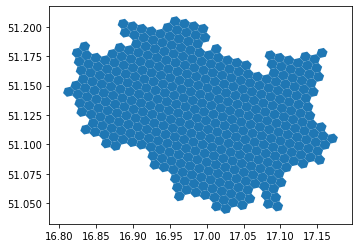

In [114]:
h3_gdf = gpd.GeoDataFrame(h3_df).set_crs(epsg=4326)
h3_gdf.plot()

In [113]:
h3_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 422 entries, 0 to 421
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   id           422 non-null    object  
 1   coordinates  422 non-null    object  
 2   geometry     422 non-null    geometry
 3   parent       422 non-null    object  
 4   children     422 non-null    object  
 5   resolution   422 non-null    int64   
dtypes: geometry(1), int64(1), object(4)
memory usage: 19.9+ KB


In [112]:
str(h3.h3_to_children(h3_hexes[0]))

"{'891e204e0c7ffff', '891e204e0d7ffff', '891e204e0cfffff', '891e204e0dbffff', '891e204e0cbffff', '891e204e0d3ffff', '891e204e0c3ffff'}"

In [116]:
h3_gdf.head(5)

,id,coordinates,geometry,parent,children,resolution
0,881e204e0dfffff,"(51.05054853944855, 17.035900904198467)","POLYGON ((17.03082 51.05377, 17.02840 51.04948...",871e204e0ffffff,"{'891e204e0c7ffff', '891e204e0d7ffff', '891e20...",8
1,881e20426dfffff,"(51.1693734758463, 16.8751892448209)","POLYGON ((16.87009 51.17258, 16.86768 51.16830...",871e20426ffffff,"{'891e20426d3ffff', '891e20426cfffff', '891e20...",8
2,881e20470dfffff,"(51.14043148339845, 17.08670832610585)","POLYGON ((17.08162 51.14365, 17.07920 51.13937...",871e20470ffffff,"{'891e20470cfffff', '891e20470dbffff', '891e20...",8
3,881e204283fffff,"(51.151189097960504, 17.023719146413587)","POLYGON ((17.01863 51.15440, 17.01621 51.15012...",871e20428ffffff,"{'891e204283bffff', '891e2042823ffff', '891e20...",8
4,881e204665fffff,"(51.16926556600536, 17.1237901117608)","POLYGON ((17.11870 51.17248, 17.11628 51.16821...",871e20466ffffff,"{'891e2046653ffff', '891e2046647ffff', '891e20...",8


In [186]:
from shapely.geometry import LineString, Polygon
from typing import List

def get_hexagons_for_line(line: LineString, hexagons_gdf: gpd.GeoDataFrame) -> List[str]:
    return hexagons_gdf[hexagons_gdf.intersects(line)]["id"].to_list()
    

In [187]:
hexes_for_lines = edges["geometry"].progress_apply(lambda x: get_hexagons_for_line(x, h3_gdf))

100%|██████████| 9683/9683 [01:20<00:00, 119.87it/s]


In [200]:
edges["hex_id"] = hexes_for_lines

In [201]:
# edges.explode("hex_id").reset_index(drop=True).to_file(join(GENERATED_DATA_DIR, place_name, "edges_drive_hex.geojson"), driver="GeoJSON")
edges_hex = edges.explode("hex_id").reset_index(drop=True)

In [285]:
hex_feautres = edges_hex.groupby(by="hex_id").sum().drop(columns=["index", "u", "v", "key", "from", "to", "length", "oneway"]).astype(str)

none_cols = list(filter(lambda x: "None" in x, hex_feautres.columns))
hex_feautres.drop(columns=none_cols, inplace=True)
hex_feautres

,oneway_0,oneway_1,lanes_1,lanes_2,lanes_3,lanes_4,lanes_5,lanes_6,lanes_7,highway_living_street,...,junction_roundabout,width_1.5,width_2,width_2.5,width_3,width_4,width_4.5,width_6,tunnel_building_passage,tunnel_yes
hex_id,,,,,,,,,,,,,,,,,,,,,
881e204001fffff,18,6,0,3,1,0,0,0,0,11,...,2,0,0,0,0,0,0,0,1,0
881e204003fffff,29,14,1,17,4,2,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
881e204005fffff,2,24,6,16,4,2,0,0,0,0,...,9,0,0,0,0,0,0,0,0,0
881e204007fffff,5,26,5,23,5,1,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
881e204009fffff,32,2,0,6,3,2,0,0,0,7,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
881e2055a5fffff,0,2,0,2,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
881e2055b1fffff,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
881e2055b3fffff,32,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [515]:
from sklearn.feature_extraction.text import TfidfTransformer

v = TfidfTransformer()
x = v.fit_transform(hex_feautres)
hex_features_tfidf = pd.DataFrame(x.toarray(), index=hex_feautres.index, columns=hex_feautres.columns)
hex_features_tfidf

,oneway_0,oneway_1,lanes_1,lanes_2,lanes_3,lanes_4,lanes_5,lanes_6,lanes_7,highway_living_street,...,junction_roundabout,width_1.5,width_2,width_2.5,width_3,width_4,width_4.5,width_6,tunnel_building_passage,tunnel_yes
hex_id,,,,,,,,,,,,,,,,,,,,,
881e204001fffff,0.524194,0.262248,0.000000,0.122223,0.053559,0.000000,0.0,0.0,0.0,0.545798,...,0.180973,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.120666,0.0
881e204003fffff,0.439743,0.318617,0.030045,0.360629,0.111551,0.070264,0.0,0.0,0.0,0.051671,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
881e204005fffff,0.025734,0.463476,0.152967,0.288009,0.094656,0.059622,0.0,0.0,0.0,0.000000,...,0.359818,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
881e204007fffff,0.066802,0.521353,0.132361,0.429889,0.122857,0.030954,0.0,0.0,0.0,0.045527,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
881e204009fffff,0.611703,0.057380,0.000000,0.160455,0.105469,0.088577,0.0,0.0,0.0,0.227986,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
881e2055a5fffff,0.000000,0.177131,0.000000,0.165106,0.217053,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
881e2055b1fffff,0.684898,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
881e2055b3fffff,0.734654,0.034457,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [336]:
import hdbscan
import plotly.express as px
import umap

In [489]:
mapper = umap.UMAP(n_neighbors=4, metric="euclidean").fit(hex_features_tfidf.values)
embedding = mapper.transform(hex_features_tfidf.values)

In [492]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=6, metric="euclidean")
embedding_df = pd.DataFrame(embedding, columns=["x", "y"])

# cluster_labels = clusterer.fit_predict(hex_features_tfidf)
cluster_labels = clusterer.fit_predict(embedding_df)

embedding_df["cluster"] = cluster_labels
embedding_df["cluster"] = embedding_df["cluster"].astype("category")
fig = px.scatter(embedding_df, x="x", y="y", color="cluster", width=800, height=700)
fig.show()

In [493]:
embedding_df.index = hex_feautres.index

In [494]:
hex_features = hex_feautres.join(embedding_df)

In [495]:
h3_gdf = h3_gdf.rename(columns={"id": "hex_id"}).set_index("hex_id")

KeyError: "None of ['hex_id'] are in the columns"

In [496]:
hex_gdf = h3_gdf.join(hex_features)

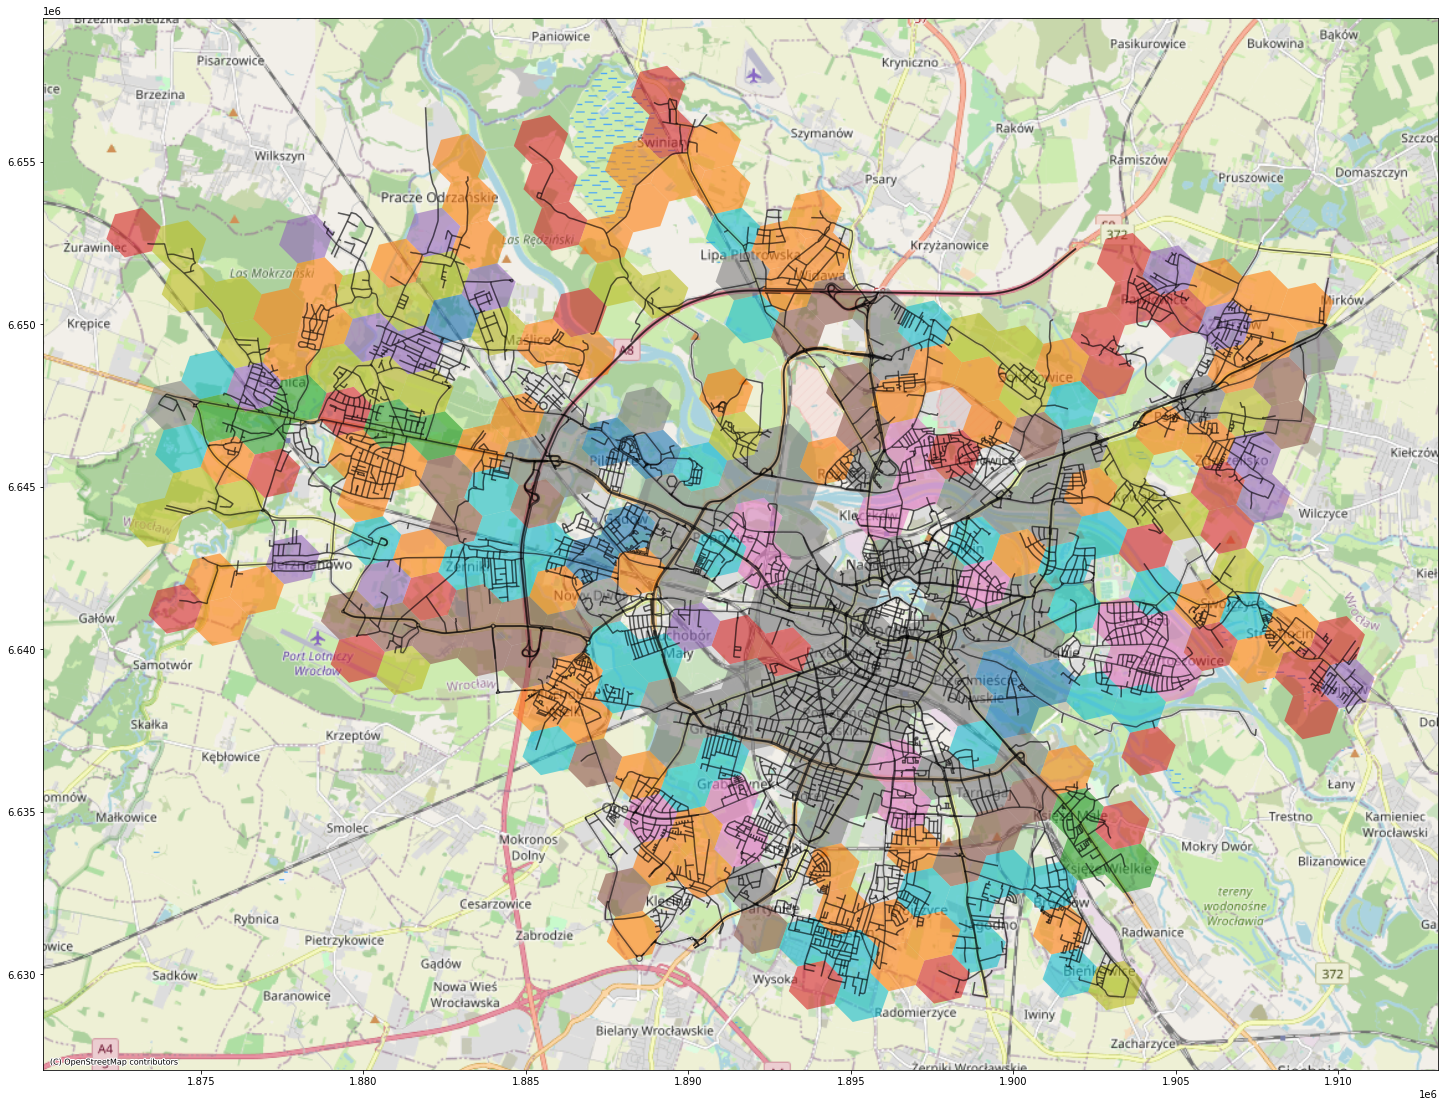

In [563]:
import matplotlib.pyplot as plt
import contextily as ctx
fig, ax = plt.subplots(1, 1, figsize=(25,20))
ax.set_aspect('equal')
# hex_gdf.plot(column='cluster', ax=ax)
hex_gdf[hex_gdf["cluster"] != -1].to_crs(epsg=3857).plot(column='cluster', ax=ax, alpha=0.6)
edges.to_crs(epsg=3857).plot(ax=ax, color="black", alpha=0.6)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

In [521]:
hex_group_cluster = hex_features_tfidf.join(embedding_df).groupby(by="cluster")

In [532]:
hex_agg = hex_group_cluster.mean().reset_index()
hex_agg

,cluster,oneway_0,oneway_1,lanes_1,lanes_2,lanes_3,lanes_4,lanes_5,lanes_6,lanes_7,...,width_2,width_2.5,width_3,width_4,width_4.5,width_6,tunnel_building_passage,tunnel_yes,x,y
0,-1,0.393609,0.158688,0.094724,0.144543,0.080153,0.028371,0.000886,0.000000,0.00000,...,0.000000,0.000000,0.01327,0.026120,0.001126,0.000719,0.001356,0.007081,8.320009,1.796130
1,0,0.554755,0.105789,0.072587,0.415968,0.029079,0.000000,0.005027,0.000000,0.00000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.013072,0.008687,13.125660,7.417363
2,1,0.602103,0.064139,0.016837,0.088999,0.025411,0.004720,0.000000,0.000000,0.00000,...,0.001494,0.000000,0.00000,0.000000,0.004567,0.000000,0.003424,0.000749,15.393028,6.464591
3,2,0.399651,0.054894,0.010477,0.051704,0.014773,0.011610,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,11.372516,-4.805678
4,3,0.641856,0.078798,0.016664,0.205371,0.022515,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,16.743145,-0.991927
5,4,0.648181,0.061065,0.000000,0.004814,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,17.974388,-0.525056
6,5,0.638299,0.014382,0.001037,0.009446,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,15.085171,1.087413
7,6,0.732338,0.022982,0.002140,0.029788,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.017248,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,14.932913,2.492981
8,7,0.131796,0.407966,0.106202,0.305695,0.083276,0.038325,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,3.273096,5.219829
9,8,0.503300,0.000000,0.000000,0.385958,0.205126,0.030957,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,10.369123,0.784149


In [546]:
fig = px.bar(hex_agg, x="cluster", y=list(filter(lambda x: "bridge" in x, hex_agg.columns)), barmode="group", width=1300)
fig.show()